In [1]:
import math, random, time, copy, builtins, functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from torch import optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision.models as models


In [2]:
print = functools.partial(builtins.print, flush=True)


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
# Cố định seed để tái hiện kết quả
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## ---------------------------- 1. Config ----------------------------------


In [4]:
ROLLOUT_STEPS = 4        # số bước (epoch) trước mỗi lần cập nhật PPO
GAMMA = 0.99             # hệ số chiết khấu cho reward
LAMBDA_GAE = 0.95        # hệ số lambda cho GAE (Generalized Advantage Estimation)
PPO_EPOCHS = 4           # số lần lặp cập nhật PPO cho mỗi batch dữ liệu
CLIP_EPS = 0.1           # phạm vi clipping cho PPO
ENT_COEF = 1e-2          # hệ số trọng số entropy (khuyến khích khám phá)
LR_POLICY = 3e-4         # learning rate cho network policy (diễn viên)
LR_VALUE  = 1e-3         # learning rate cho network value (phê bình)
STATE_DIM = 7            # kích thước vector trạng thái (định nghĩa bên dưới)
ACTION_DIM = 2           # số hành động (0: SGD, 1: Adam, 2: SAM)
# Hệ số tính reward
W_ACC = 100.0            # trọng số cho thay đổi accuracy
W_LOSS = 1.0             # trọng số cho thay đổi loss
W_TIME = 0.03             # trọng số phạt thời gian (epoch lâu sẽ bị trừ reward)
FINAL_BONUS_W = 50.0     # trọng số thưởng thêm cuối cùng dựa trên độ chính xác validation
LOSS_SCALE = 2.0         # hệ số scale cho loss (để giá trị loss và acc ở cùng mức độ)
WEIGHT_DECAY = 5e-4      # weight decay áp dụng cho các optimizer


SAM


In [5]:
class SAM(optim.Optimizer):
    """Optimizer SAM: Sharpness-Aware Minimization (với hai bước cập nhật)."""
    def __init__(self, params, base_optimizer, rho=0.05, grad_norm_eps=1e-12, **kwargs):
        # base_optimizer: lớp optimizer cơ sở (vd: optim.SGD)
        super().__init__(params, dict(rho=rho, grad_norm_eps=grad_norm_eps, **kwargs))
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
    @torch.no_grad()
    def first_step(self, zero_grad=False):
        # Bước 1: cập nhật tạm thời theo hướng tăng độ sắc nét (maximize loss)
        grad_norm = torch.norm(torch.stack([
            p.grad.norm() for group in self.param_groups
            for p in group['params'] if p.grad is not None
        ]))
        if grad_norm < self.defaults['grad_norm_eps']:
            return
        scale = self.defaults['rho'] / (grad_norm + 1e-12)
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: 
                    continue
                # Nhảy một bước nhỏ theo hướng gradient (tăng weight tạm thời)
                e_w = p.grad * scale
                p.add_(e_w)
                # Lưu e_w để dùng cho bước thứ hai
                self.state[p]['e_w'] = e_w.detach()
        if zero_grad:
            self.zero_grad()
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        # Bước 2: quay về tọa độ ban đầu và tối ưu một bước theo optimizer cơ sở
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # Quay lại trọng số ban đầu
                p.sub_(self.state[p]['e_w'])
        # Cập nhật trọng số theo optimizer cơ sở (SGD)
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

# --------------------- 3. Data -----------------------------------------


In [6]:
def get_resnet18_scratch(num_classes=10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ==== 4) Tải dữ liệu CIFAR-10 (tách train/val/test) ====
def load_cifar10(batch_train=128, batch_eval=256):
    transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)),
    ])
    transform_eval = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)),
    ])
    full_train = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set   = CIFAR10(root='./data', train=False, download=True, transform=transform_eval)
    # Tách 5,000 mẫu từ train thành validation
    val_size = 5000
    train_size = len(full_train) - val_size
    train_set, val_set = random_split(full_train, [train_size, val_size],
                                      generator=torch.Generator().manual_seed(SEED))
    dl_train = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2, pin_memory=True)
    dl_val   = DataLoader(val_set,   batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)
    dl_test  = DataLoader(test_set,  batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)
    print(f"Dataset → Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")
    return dl_train, dl_val, dl_test

# --------------------- 4. Model & Optimizers ---------------------------


In [7]:
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, ACTION_DIM)
        )
    def forward(self, x):
        return self.net(x)  # trả về logits (chưa softmax) cho mỗi hành động

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        # Trả về giá trị (scalar) đại diện cho Value function V(s)
        return self.net(x).squeeze(-1)


In [8]:
class RolloutBuffer:
    def __init__(self):
        self.clear()
    def store(self, state, action, log_prob, value, reward, done):
        # Lưu một transition (state, action, log_prob, value, reward, done) vào buffer
        self.states.append(state.detach())
        self.actions.append(action.detach())
        self.logprobs.append(log_prob.detach())
        self.values.append(value.detach())
        # Đảm bảo reward là tensor float32 trên DEVICE
        if not isinstance(reward, torch.Tensor):
            reward = torch.tensor(reward, dtype=torch.float32, device=DEVICE)
        self.rewards.append(reward)
        # done flag (float32) — 1.0 nếu xong episode, 0.0 nếu chưa
        self.dones.append(torch.tensor(float(done), device=DEVICE))
    def compute(self, next_value):
        # Tính toán lợi thế (advantage) GAE và return (target) cho từng bước sau khi rollout kết thúc
        self.advs = []
        self.rets = []
        adv = 0.0  # biến lưu trữ lợi thế tích lũy
        for i in reversed(range(len(self.rewards))):
            mask = 1.0 - self.dones[i]  # 0 nếu done, 1 nếu chưa xong (tiếp tục)
            # delta = phần tử TD-error cho bước i
            delta = self.rewards[i] + GAMMA * next_value * mask - self.values[i]
            adv = delta + GAMMA * LAMBDA_GAE * mask * adv  # GAE: tích lũy lợi thế có chiết khấu
            self.advs.insert(0, adv)                      # thêm vào đầu danh sách (do duyệt ngược)
            self.rets.insert(0, adv + self.values[i])     # return = advantage + value (Q = V + A)
            next_value = self.values[i]                   # cập nhật next_value cho bước trước đó
    def as_tensors(self):
        # Chuyển các danh sách lưu trữ sang tensor và đưa lên DEVICE
        fixed_states = [(s.unsqueeze(0) if s.dim() == 0 else s) for s in self.states]
        states   = torch.stack(fixed_states).to(DEVICE)
        actions  = torch.stack(self.actions).to(DEVICE)
        logprobs = torch.stack(self.logprobs).to(DEVICE)
        advs     = torch.stack(self.advs).to(DEVICE)
        rets     = torch.stack(self.rets).to(DEVICE)
        return states, actions, logprobs, advs, rets
    def clear(self):
        # Xóa sạch bộ nhớ
        self.states   = []
        self.actions  = []
        self.logprobs = []
        self.values   = []
        self.rewards  = []
        self.dones    = []
        self.advs     = []
        self.rets     = []

In [9]:
ID2OPT = ['sgd', 'sam']  # ánh xạ id hành động sang tên optimizer
def make_optimizer(name, model, lr):
    if name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    elif name == 'sam':
        # SAM sử dụng SGD làm optimizer cơ sở
        return SAM(model.parameters(), base_optimizer=optim.SGD, lr=lr, momentum=0.9, weight_decay=WEIGHT_DECAY)
    else:
        raise ValueError(f"Unknown optimizer name: {name}")


In [10]:
def compute_metrics(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    preds_list = []
    labels_list = []
    n_samples = 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        loss = loss_fn(logits, y)
        # Cộng dồn loss và gom nhãn dự đoán/thực tế để tính độ chính xác, precision, F1
        total_loss += loss.item() * y.size(0)
        preds_list.append(logits.argmax(dim=1).cpu())
        labels_list.append(y.cpu())
        n_samples += y.size(0)
    # Kết hợp các batch lại
    preds  = torch.cat(preds_list)
    labels = torch.cat(labels_list)
    # Tính các chỉ số
    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted", zero_division=0)
    f1   = f1_score(labels, preds, average="weighted", zero_division=0)
    avg_loss = total_loss / n_samples
    return acc, prec, f1, avg_loss


100%|██████████| 170M/170M [00:01<00:00, 92.4MB/s] 


Dataset → Train: 45000 | Val: 5000 | Test: 10000
[Ep 001] ValAcc=0.4418 | ValF1=0.4257 | Opt=SGD  | Δt=16.2s
[Ep 002] ValAcc=0.5364 | ValF1=0.5330 | Opt=SGD  | Δt=14.5s
[Ep 003] ValAcc=0.5904 | ValF1=0.5924 | Opt=SGD  | Δt=14.2s
[Ep 004] ValAcc=0.6008 | ValF1=0.6054 | Opt=SGD  | Δt=14.8s
[Ep 005] ValAcc=0.6422 | ValF1=0.6425 | Opt=SAM  | Δt=21.7s
[Ep 006] ValAcc=0.6682 | ValF1=0.6655 | Opt=SGD  | Δt=14.6s
[Ep 007] ValAcc=0.6860 | ValF1=0.6810 | Opt=SAM  | Δt=21.9s
[Ep 008] ValAcc=0.6916 | ValF1=0.6887 | Opt=SGD  | Δt=14.5s
[Ep 009] ValAcc=0.6984 | ValF1=0.6996 | Opt=SAM  | Δt=22.6s
[Ep 010] ValAcc=0.7212 | ValF1=0.7218 | Opt=SGD  | Δt=14.3s
[Ep 011] ValAcc=0.7242 | ValF1=0.7242 | Opt=SGD  | Δt=14.3s
[Ep 012] ValAcc=0.7366 | ValF1=0.7357 | Opt=SAM  | Δt=22.4s
[Ep 013] ValAcc=0.7342 | ValF1=0.7292 | Opt=SAM  | Δt=22.3s
[Ep 014] ValAcc=0.7528 | ValF1=0.7531 | Opt=SGD  | Δt=14.4s
[Ep 015] ValAcc=0.7358 | ValF1=0.7370 | Opt=SGD  | Δt=14.8s
[Ep 016] ValAcc=0.7470 | ValF1=0.7498 | Opt=SAM  | 

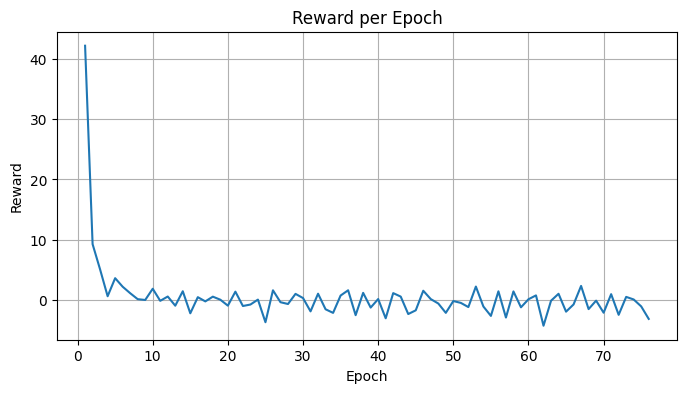

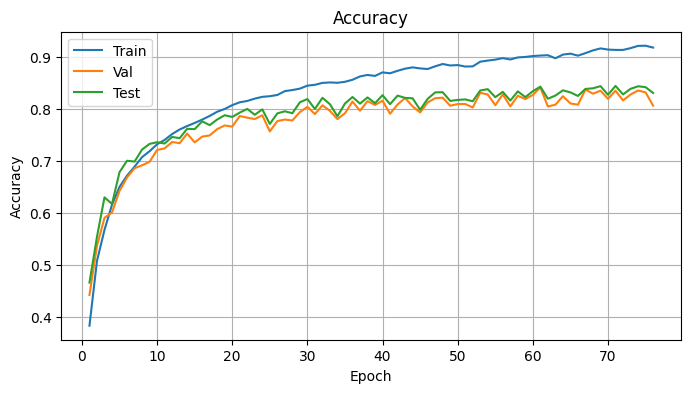

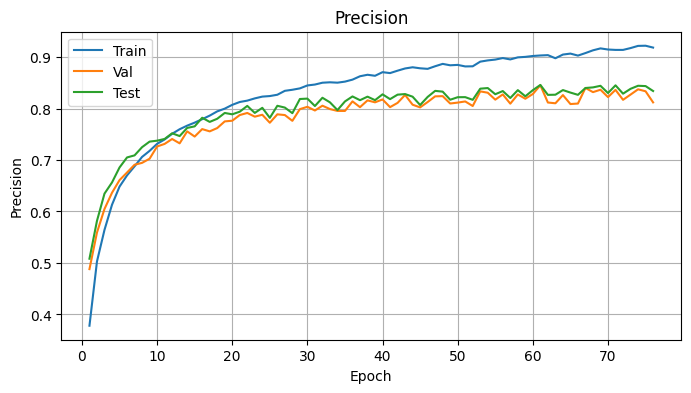

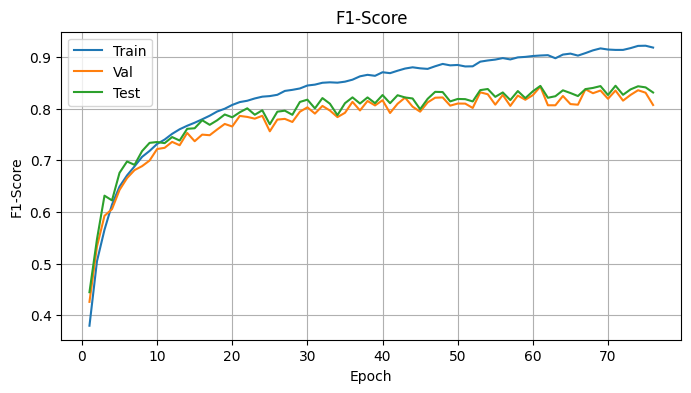

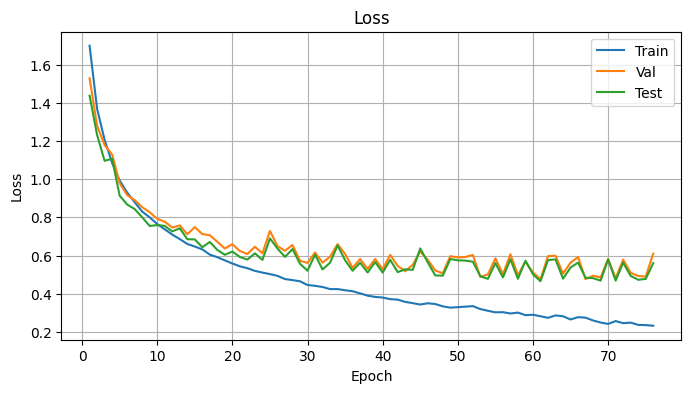

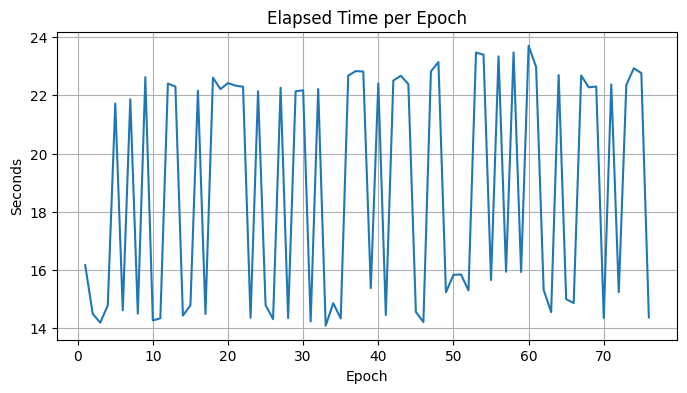

In [11]:
class OptimizerRLTrainer:
    def __init__(self, model, dl_train, dl_val, dl_test, n_epochs=150, patience=10):
        self.model = model.to(DEVICE)
        self.dl_train = dl_train
        self.dl_val   = dl_val
        self.dl_test  = dl_test
        self.n_epochs = n_epochs
        self.patience = patience
        # Khởi tạo network cho Policy (chọn hành động) và Value (ước lượng V)
        self.policy = PolicyNet().to(DEVICE)
        self.value  = ValueNet().to(DEVICE)
        self.opt_policy = optim.Adam(self.policy.parameters(), lr=LR_POLICY)
        self.opt_value  = optim.Adam(self.value.parameters(),  lr=LR_VALUE)
        # Lịch sử các chỉ số theo từng epoch
        self.hist = {k: [] for k in [
            "train_acc", "val_acc", "test_acc",
            "train_prec", "val_prec", "test_prec",
            "train_f1", "val_f1", "test_f1",
            "train_loss", "val_loss", "test_loss",
            "reward", "action", "time"
        ]}
        # Theo dõi mô hình có độ chính xác val tốt nhất (để so sánh)
        self.best_val = 0.0
        self.best_epoch = 0
        self.best_test_acc = 0.0
        self.best_test_loss = 0.0
        self.best_state = None  # lưu state_dict của model tốt nhất

    def _ppo_update(self, buffer):
        # Cập nhật network chính sách (policy) và value function theo PPO dùng dữ liệu trong buffer
        states, actions, old_logprobs, advs, rets = buffer.as_tensors()
        # Chuẩn hóa advantage để ổn định
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        # Thực hiện PPO cập nhật liên tiếp PPO_EPOCHS lần
        for _ in range(PPO_EPOCHS):
            # Tính xác suất (logits) và entropy theo policy hiện tại
            dist    = tdist.Categorical(logits=self.policy(states))
            new_logprob = dist.log_prob(actions)
            # Tính tỉ lệ xác suất mới / cũ
            ratio   = torch.exp(new_logprob - old_logprobs)
            # Tính 2 phần tử của hàm mục tiêu PPO
            surr1 = ratio * advs
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * advs
            # Tính loss cho policy: âm của min(surr1, surr2) + entropy bonus (để maximize)
            policy_loss = -(torch.min(surr1, surr2) + ENT_COEF * dist.entropy()).mean()
            # Cập nhật mạng policy
            self.opt_policy.zero_grad()
            policy_loss.backward()
            self.opt_policy.step()
            # Tính loss cho value function (mean squared error giữa return mục tiêu và giá trị ước lượng)
            value_pred = self.value(states)
            value_loss = F.mse_loss(value_pred, rets)
            # Cập nhật mạng value
            self.opt_value.zero_grad()
            value_loss.backward()
            self.opt_value.step()

    def fit(self):
        loss_fn = nn.CrossEntropyLoss()
        buffer = RolloutBuffer()
        # Các biến trạng thái ban đầu (cho epoch 0)
        prev_val_acc = 0.0
        prev_val_loss = 0.0
        delta_acc_prev = 0.0
        delta_loss_prev = 0.0
        prev_action = 0           # giả định optimizer trước đó là SGD (id=0) lúc bắt đầu
        patience_counter = 0      # đếm số epoch liên tiếp không cải thiện val_acc

        for ep in range(self.n_epochs):
            t0 = time.time()
            # 1) Tạo vector trạng thái cho epoch hiện tại
            state = torch.tensor([
                prev_val_acc,
                prev_val_loss / LOSS_SCALE,
                delta_acc_prev,
                delta_loss_prev,
                ep / self.n_epochs,
                *[int(prev_action == i) for i in range(ACTION_DIM)]
            ], dtype=torch.float32, device=DEVICE)
            # Vector trạng thái gồm:
            # [val_acc (trước đó), val_loss (trước đó, đã scale), 
            #  delta_val_acc (trước đó), delta_val_loss (trước đó),
            #  tỉ lệ epoch hiện tại, one-hot hành động trước đó (3 phần tử)]

            # 2) Policy chọn một optimizer (hành động)
            dist = tdist.Categorical(logits=self.policy(state))
            action = dist.sample()                # chọn hành động (0, 1 hoặc 2)
            log_prob = dist.log_prob(action)      # log-probability của hành động đã chọn
            opt_idx = action.item()
            opt_name = ID2OPT[opt_idx]
            # Chọn learning rate cho optimizer: Adam dùng lr=1e-3, còn lại lr=1e-2
            lr = 1e-3 if opt_name == "adam" else 1e-2
            optimizer = make_optimizer(opt_name, self.model, lr)

            # 3) Huấn luyện mô hình trong 1 epoch với optimizer đã chọn
            self.model.train()
            total_loss = 0.0
            total_correct = 0
            total_samples = 0
            train_preds, train_labels = [], []
            for X, y in self.dl_train:
                X, y = X.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                logits = self.model(X)
                loss   = loss_fn(logits, y)
                if opt_name == "sam":
                    # Nếu optimizer là SAM: thực hiện hai bước cập nhật
                    loss.backward()
                    optimizer.first_step(zero_grad=True)   # bước 1: di chuyển đến điểm sắc nét
                    # Tính loss tại điểm sắc nét (model đã thay đổi sau first_step)
                    logits_sam = self.model(X)
                    loss_sam = loss_fn(logits_sam, y)
                    loss_sam.backward()
                    optimizer.second_step(zero_grad=True)  # bước 2: cập nhật trọng số theo SGD
                else:
                    # Optimizer thường (SGD hoặc Adam): chỉ một bước
                    loss.backward()
                    optimizer.step()
                # Cập nhật thống kê train
                total_loss    += loss.item() * y.size(0)
                total_correct += (logits.argmax(dim=1) == y).sum().item()
                total_samples += y.size(0)
                train_preds.append(logits.argmax(dim=1).cpu())
                train_labels.append(y.cpu())
            # Tính các chỉ số train sau epoch
            train_preds  = torch.cat(train_preds)
            train_labels = torch.cat(train_labels)
            train_acc  = total_correct / total_samples
            train_prec = precision_score(train_labels, train_preds, average="weighted", zero_division=0)
            train_f1   = f1_score(train_labels, train_preds, average="weighted", zero_division=0)
            train_loss = total_loss / total_samples

            # 4) Đánh giá trên tập validation và test
            val_acc,  val_prec,  val_f1,  val_loss  = compute_metrics(self.model, self.dl_val)
            test_acc, test_prec, test_f1, test_loss = compute_metrics(self.model, self.dl_test)

            # 5) Kiểm tra cải thiện trên validation để lưu model tốt nhất (checkpoint)
            if val_acc > self.best_val:
                # Nếu val_acc tốt hơn trước, cập nhật thông tin model tốt nhất
                self.best_val = val_acc
                self.best_epoch = ep + 1
                self.best_test_acc = test_acc
                self.best_test_loss = test_loss
                self.best_state = copy.deepcopy(self.model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            # 6) Tính reward dựa trên thay đổi độ chính xác/loss và thời gian huấn luyện
            delta_acc  = val_acc - prev_val_acc       # thay đổi Val Acc so với epoch trước
            delta_loss = prev_val_loss - val_loss     # giảm bớt Val Loss so với epoch trước
            elapsed    = time.time() - t0             # thời gian huấn luyện epoch (giây)
            # Reward: tăng nếu val_acc tăng hoặc val_loss giảm, trừ đi nếu tốn nhiều thời gian
            reward = W_ACC * delta_acc + W_LOSS * delta_loss - W_TIME * elapsed
            # Nếu là epoch cuối (kết thúc episode), thưởng thêm dựa trên val_acc hiện tại
            if ep == self.n_epochs - 1:
                reward += FINAL_BONUS_W * val_acc

            # Lưu transition vào buffer
            done = (ep == self.n_epochs - 1)  # True nếu là epoch cuối
            buffer.store(state, action, log_prob, self.value(state).detach(), reward, done)
            # Nếu đã thu thập đủ ROLLOUT_STEPS bước, hoặc đã kết thúc episode, thì cập nhật PPO
            if (ep + 1) % ROLLOUT_STEPS == 0 or done:
                next_val = torch.tensor(0.0, device=DEVICE)
                if not done:
                    # Nếu chưa done, ước lượng giá trị của state kế tiếp để làm next_value (bootstrap)
                    next_val = self.value(state).detach()
                buffer.compute(next_val)
                self._ppo_update(buffer)
                buffer.clear()

            # 7) Lưu lại lịch sử các chỉ số cho epoch này
            self.hist["train_acc"].append(train_acc);   self.hist["val_acc"].append(val_acc);   self.hist["test_acc"].append(test_acc)
            self.hist["train_prec"].append(train_prec); self.hist["val_prec"].append(val_prec); self.hist["test_prec"].append(test_prec)
            self.hist["train_f1"].append(train_f1);     self.hist["val_f1"].append(val_f1);     self.hist["test_f1"].append(test_f1)
            self.hist["train_loss"].append(train_loss); self.hist["val_loss"].append(val_loss); self.hist["test_loss"].append(test_loss)
            self.hist["reward"].append(reward)
            self.hist["action"].append(opt_idx)
            self.hist["time"].append(elapsed)

            # 8) In log thông tin epoch ra màn hình
            print(f"[Ep {ep+1:03}] ValAcc={val_acc:.4f} | ValF1={val_f1:.4f} | "
                  f"Opt={opt_name.upper():4} | Δt={elapsed:.1f}s")

            # 9) Cập nhật các biến trạng thái cho epoch tiếp theo
            prev_val_acc  = val_acc
            prev_val_loss = val_loss
            delta_acc_prev  = delta_acc
            delta_loss_prev = delta_loss
            prev_action = opt_idx

            # Kiểm tra dừng sớm (early stopping)
            if patience_counter >= self.patience:
                print(f"⏹ Early stop at epoch {ep + 1}")
                done = True
                break  # kết thúc sớm nếu không cải thiện trong self.patience epoch liên tiếp

        # Nếu dừng sớm trước n_epochs, thực hiện cập nhật PPO lần cuối cho các bước còn lại trong buffer
        if ep < self.n_epochs - 1:
            if len(buffer.states) > 0:
                buffer.compute(torch.tensor(0.0, device=DEVICE))
                self._ppo_update(buffer)
                buffer.clear()

# ==== 10) Sử dụng các hàm/lớp trên để huấn luyện mô hình với PPO ====
# 1. Tải dữ liệu
dl_train, dl_val, dl_test = load_cifar10()
# 2. Tạo mô hình ResNet-18 mới (train từ đầu)
model = get_resnet18_scratch(num_classes=10)
# 3. Khởi tạo trainer và bắt đầu huấn luyện
trainer = OptimizerRLTrainer(model, dl_train, dl_val, dl_test, n_epochs=150, patience=15)
trainer.fit()

# 4. Xuất bảng reward và bảng chỉ số đầy đủ sau huấn luyện
reward_df = pd.DataFrame({
    "Epoch": range(1, len(trainer.hist["reward"]) + 1),
    "Reward": trainer.hist["reward"],
})
print("\n===== REWARD TABLE =====")
print(reward_df.to_string(index=False))
# ----- BEST-VAL summary -------------------------------------------------
best_idx = int(np.argmax(trainer.hist["val_acc"]))   # vị trí epoch tốt nhất
print("\n===== BEST (Val Acc) =====")
print(f"Epoch {best_idx+1} | "
      f"ValAcc {trainer.hist['val_acc'][best_idx]:.4f} | "
      f"TestAcc {trainer.hist['test_acc'][best_idx]:.4f} | "
      f"TestLoss {trainer.hist['test_loss'][best_idx]:.4f}")

full_df = pd.DataFrame(trainer.hist).rename(columns={"time": "Time(s)"})
full_df.index = full_df.index + 1  # đặt index bắt đầu từ 1 (tương ứng số epoch)
full_df.index.name = "Epoch"
print("\n===== FULL METRICS TABLE =====")
print(full_df.to_string())

# 5. Vẽ các biểu đồ theo yêu cầu (reward, accuracy, loss, precision, F1, time)
epochs = range(1, len(trainer.hist["reward"]) + 1)

# Biểu đồ reward mỗi epoch
plt.figure(figsize=(8, 4))
plt.plot(reward_df["Epoch"], reward_df["Reward"])
plt.title("Reward per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Biểu đồ Accuracy (Train/Val/Test)
plt.figure(figsize=(8, 4))
plt.plot(epochs, trainer.hist["train_acc"], label="Train")
plt.plot(epochs, trainer.hist["val_acc"],   label="Val")
plt.plot(epochs, trainer.hist["test_acc"],  label="Test")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()

# Biểu đồ Precision (Train/Val/Test)
plt.figure(figsize=(8, 4))
plt.plot(epochs, trainer.hist["train_prec"], label="Train")
plt.plot(epochs, trainer.hist["val_prec"],   label="Val")
plt.plot(epochs, trainer.hist["test_prec"],  label="Test")
plt.title("Precision")
plt.xlabel("Epoch"); plt.ylabel("Precision")
plt.legend(); plt.grid(True)
plt.show()

# Biểu đồ F1-score (Train/Val/Test)
plt.figure(figsize=(8, 4))
plt.plot(epochs, trainer.hist["train_f1"], label="Train")
plt.plot(epochs, trainer.hist["val_f1"],   label="Val")
plt.plot(epochs, trainer.hist["test_f1"],  label="Test")
plt.title("F1-Score")
plt.xlabel("Epoch"); plt.ylabel("F1-Score")
plt.legend(); plt.grid(True)
plt.show()

# Biểu đồ Loss (Train/Val/Test)
plt.figure(figsize=(8, 4))
plt.plot(epochs, trainer.hist["train_loss"], label="Train")
plt.plot(epochs, trainer.hist["val_loss"],   label="Val")
plt.plot(epochs, trainer.hist["test_loss"],  label="Test")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()

# Biểu đồ thời gian (độ trễ mỗi epoch)
plt.figure(figsize=(8, 4))
plt.plot(epochs, trainer.hist["time"])
plt.title("Elapsed Time per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Seconds")
plt.grid(True)
plt.show()